In [1]:
# make sure packages are installed
import subprocess
def install_package(package_name):
    subprocess.check_call(["pip", "install", package_name])

install_package("numpy")
install_package("pandas")
install_package("matplotlib")
install_package("ipympl")
install_package("ipywidgets")
install_package("mplcursors")

In [2]:
%matplotlib widget

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import ipywidgets as widgets
import mplcursors as mplc

filename_snapshot = "Dataset/snapshots_arabia_t_5040.csv"
filename_overview = "Dataset/aoe_data.csv"

In [3]:
data        = pd.read_csv(filename_snapshot)
print("Loaded data")

overview    = pd.read_csv(filename_overview)
print("Loaded overview", )

Loaded data
Loaded overview


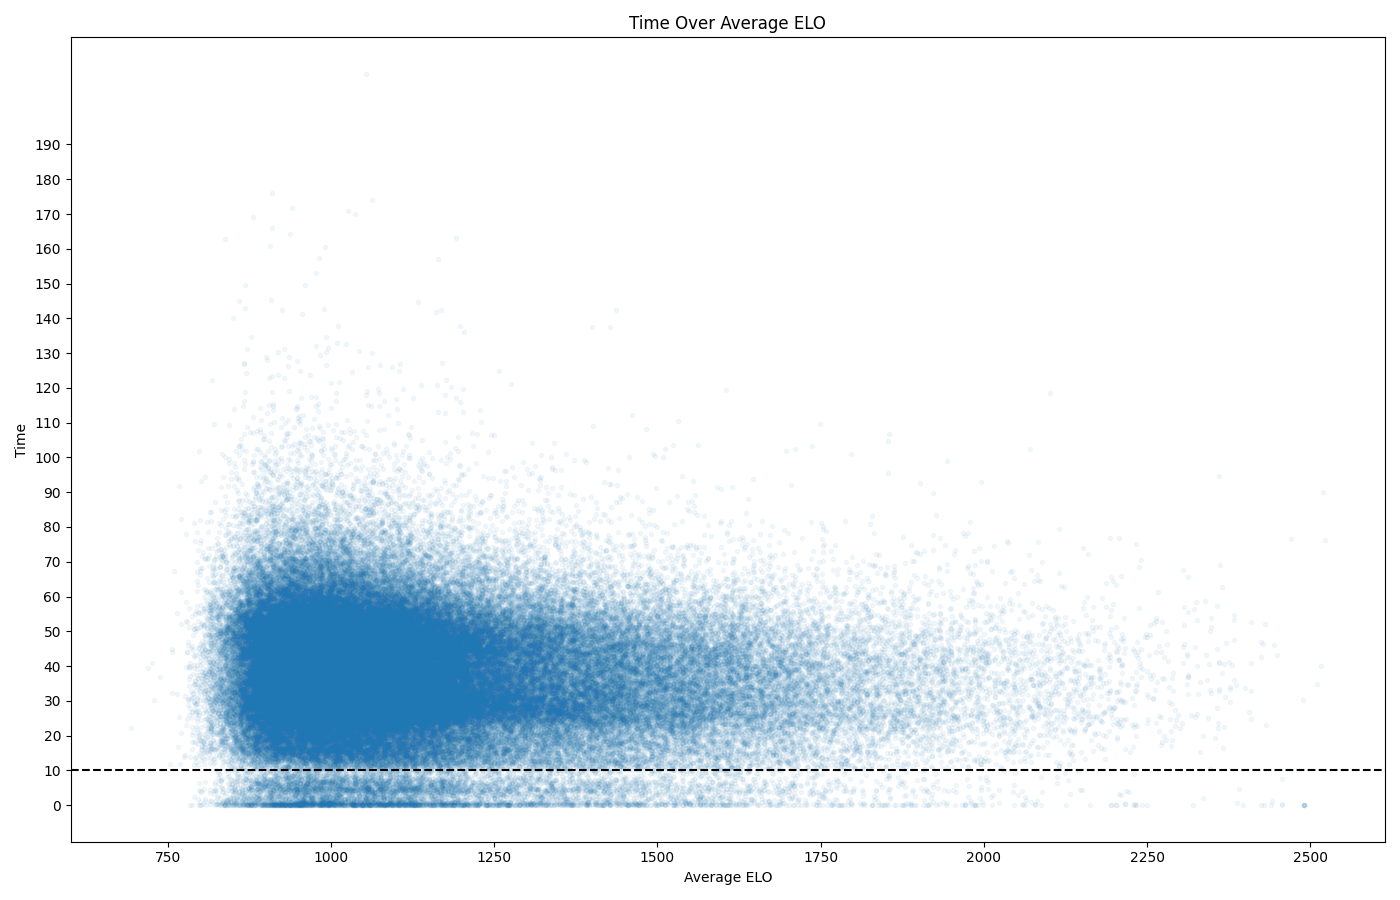

In [4]:
# Player ELO game duration correlation

plt.figure(figsize=(14, 9))
plt.title("Time Over Average ELO")
plt.xlabel("Average ELO")
plt.ylabel("Time")

plt.axhline(60 * 10, color="black", ls="--")
# plt.axhline(60 * 20, color="black", ls="--")

data_x = data["avg_elo"]
data_y = data["duration"]
data_order = np.argsort(data_x)
plt.scatter(data_x[data_order], data_y[data_order], marker='.', alpha=0.05)

plt.yticks(ticks=np.arange(0, 20) * (60 * 10), labels=np.arange(0, 20) * 10)

plt.tight_layout()

plt.show()

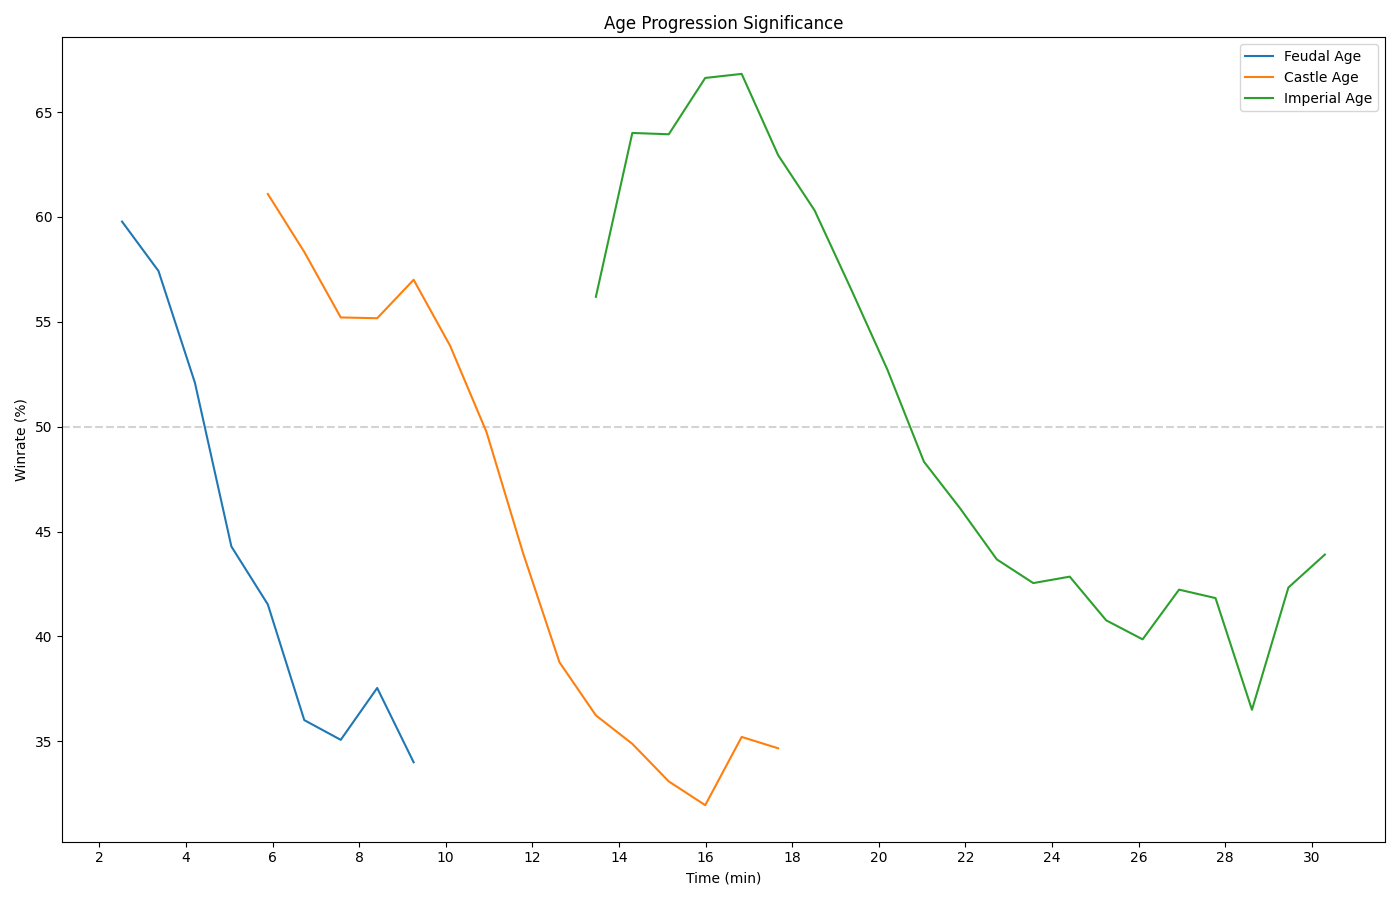

In [5]:
# Age progression significance

data_win = data["winner"]
data_times = [
    [
        data["p1 Feudal Age Time"],
        data["p1 Castle Age Time"],
        data["p1 Imperial Age Time"]
    ],
    [
        data["p2 Feudal Age Time"],
        data["p2 Castle Age Time"],
        data["p2 Imperial Age Time"]
    ]
]

data_x = np.linspace(0, 5000, 100)

wins    = np.zeros((3, 100))
losses  = np.zeros((3, 100))

for i, winner in enumerate(data_win):
    for j in range(0, 2):
        t = data_times[j]
        for k, age in enumerate(t):
            time = age[i]
            bucket = (time + 50) // 100
            if bucket >= 100 or bucket < 0:
                continue
            (wins if (winner == j) else losses)[k][bucket] += 1

min_datapoints = 50
data_y = [[], [], []]
for i in range(3):
    for j in range(100):
        w = wins[i][j]
        l = losses[i][j]
        if j == 0 or w < min_datapoints or l < min_datapoints:
            data_y[i].append(float('nan'))
            continue
        winrate = (w / (w + l)) * 100
        data_y[i].append(winrate)
        
plt.figure(figsize=(14, 9))
plt.title("Age Progression Significance")
plt.xlabel("Time (min)")
plt.ylabel("Winrate (%)")

xtick_count = 20
plt.xticks(np.arange(xtick_count) * 60 * 2, np.arange(xtick_count) * 2)

plt.axhline(50, color="lightgrey", ls="--")

plt.plot(data_x, data_y[0], label="Feudal Age")
plt.plot(data_x, data_y[1], label="Castle Age")
plt.plot(data_x, data_y[2], label="Imperial Age")

plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

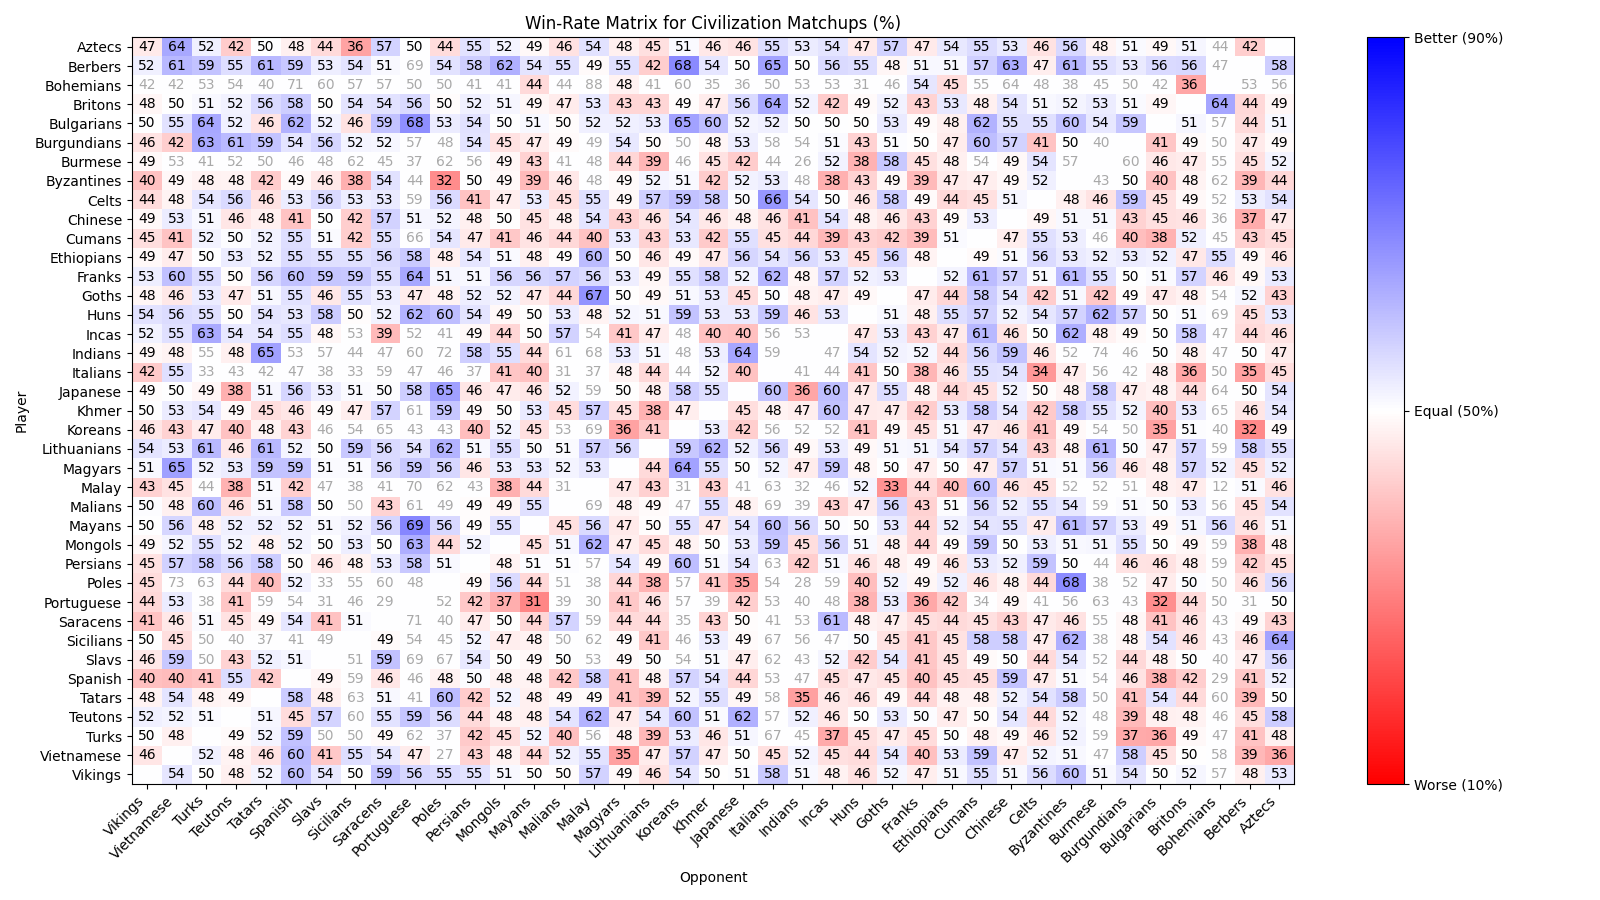

In [6]:
# Civilization matchup matrix

data_x = data["p1_civ"]
data_y = data["p2_civ"]

data_win = data["winner"]

unique_civs = []

for x in data_x:
    if x not in unique_civs:
        unique_civs.append(x)

civ_play_count = np.zeros((len(unique_civs)))


for i, x in enumerate(data_x):
    civ_play_count[unique_civs.index(x)] += 1

for i, x in enumerate(data_y):
    civ_play_count[unique_civs.index(x)] += 1

# for i, x in enumerate(unique_civs):
#     print(str(x)  + " - " + str(civ_play_count[i]))

unique_civs = sorted(unique_civs)
civ_count = len(unique_civs)
heat_grid = np.zeros((civ_count, civ_count))
tally_grid = np.zeros((civ_count, civ_count))

for i, x in enumerate(data_x):
    civ_index = unique_civs.index(x)
    opp_index = unique_civs.index(data_y[i])
    win = data_win[i] == 0
    heat_grid[civ_index][civ_count - opp_index - 1] += (1 if win else 0) if (opp_index is not civ_index) else (0.5)
    heat_grid[opp_index][civ_count - civ_index - 1] += (0 if win else 1) if (opp_index is not civ_index) else (0.5)
    tally_grid[civ_index][civ_count - opp_index - 1] += 1
    tally_grid[opp_index][civ_count - civ_index - 1] += 1

value_min = np.min(heat_grid)
value_max = np.max(heat_grid)
value_greater = max(value_min, value_max)

heat_grid_weighted = np.divide(heat_grid, tally_grid)
heat_grid_filtered = np.copy(heat_grid_weighted)

min_datapoints = 50
for x in range(civ_count):
    for y in range(civ_count):
        if tally_grid[x, y] < min_datapoints:
            heat_grid_filtered[x, y] = 0.5

plt.figure(figsize=(16, 9))
plt.xticks(np.arange(civ_count), labels=np.flip(unique_civs), rotation=45, ha='right')
plt.yticks(np.arange(civ_count), labels=unique_civs)
plt.xlabel("Opponent")
plt.ylabel("Player")
heatmap = plt.imshow(heat_grid_filtered, aspect="auto", cmap="bwr_r", clim=(0.1, 0.9)) # , clim=(-value_greater * 2, value_greater * 2)

plt.title("Win-Rate Matrix for Civilization Matchups (%)")

# plt.tight_layout()

cbar = plt.colorbar(heatmap, ticks=[0.1, 0.5, 0.9]) 
cbar.ax.set_yticklabels(["Worse (10%)", "Equal (50%)", "Better (90%)"])  # vertically oriented colorbar

for i in range(civ_count):
    for j in range(civ_count):
        if i != civ_count - j - 1:
            value = heat_grid_weighted[i, j]
            # value_string = "{:.2f}".format(value)
            value_string = str(round(value * 100))
            if tally_grid[i, j] >= min_datapoints:
                plt.text(j, i, value_string,
                    ha="center", va="center", color="black")
            else:
                plt.text(j, i, value_string,
                    ha="center", va="center", color="darkgray")
                
plt.tight_layout()

plt.show()

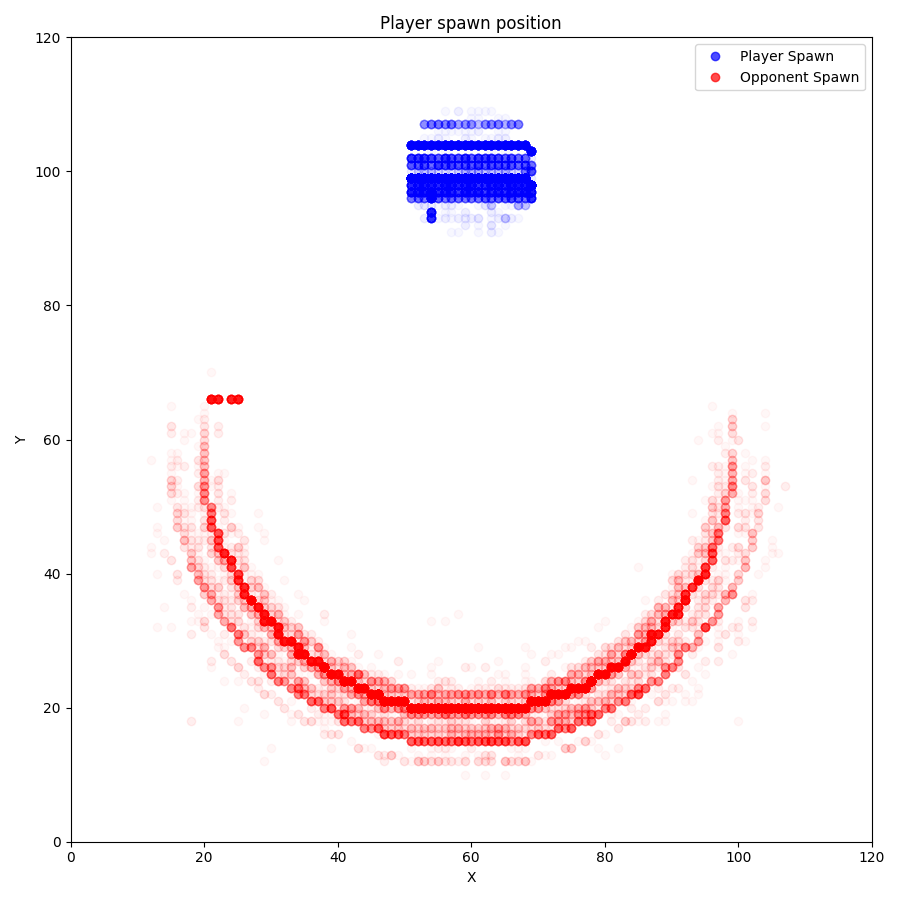

In [21]:
# Player town center spawn correlation

map_width = 120

# Interactive parameters
current_angle = 0
current_radius = 10
current_distance = 40

figure = plt.figure(figsize=(9, 9))
plt.title("Player spawn position")
plt.xlim(0, map_width)
plt.ylim(0, map_width)
plt.xlabel("X")
plt.ylabel("Y")

# Plots
plot_p1 = plt.plot([], [], "o", alpha=0.03, color="blue", label="Player Spawn")
plot_p2 = plt.plot([], [], "o", alpha=0.03, color="red", label="Opponent Spawn")

# Widgets
widget_angle = widgets.FloatSlider(description="Angle", value=current_angle, min=0.0, max=math.pi * 2)
widget_radius = widgets.FloatSlider(description="Radius", value=current_radius, min=0.0, max=40)
widget_distance = widgets.FloatSlider(description="Distance", value=current_distance, min=0.0, max=map_width / 2)

def v4_draw(angle, radius, distance):
    position = (
        map_width / 2 + distance * math.sin(angle),
        map_width / 2 + distance * math.cos(angle)
    )
    radius_squared = radius * radius
    data_filtered = overview.loc[
        (overview["p1_xpos"] - position[0]) * (overview["p1_xpos"] - position[0]) + 
        (overview["p1_ypos"] - position[1]) * (overview["p1_ypos"] - position[1]) < radius_squared
    ]
    plot_p1[0].set_xdata(data_filtered["p1_xpos"])
    plot_p1[0].set_ydata(data_filtered["p1_ypos"])
    plot_p2[0].set_xdata(data_filtered["p2_xpos"])
    plot_p2[0].set_ydata(data_filtered["p2_ypos"])

def v4_draw_with_globals():
    global current_angle
    global current_radius
    global current_distance
    v4_draw(current_angle, current_radius, current_distance)

def v4_listener_angle(change):
    global current_angle
    current_angle = change.new
    v4_draw_with_globals()

def v4_listener_radius(change):
    global current_radius
    current_radius = change.new
    v4_draw_with_globals()

def v4_listener_distance(change):
    global current_distance
    current_distance = change.new
    v4_draw_with_globals()

v4_draw_with_globals()

legend = plt.legend(loc='upper right')
for handle in legend.legend_handles: 
    handle.set_alpha(0.7)

widget_angle.observe(v4_listener_angle, names='value')
widget_radius.observe(v4_listener_radius, names='value')
widget_distance.observe(v4_listener_distance, names='value')
widget_bar = widgets.HBox(children=[widget_angle, widget_distance, widget_radius])

display(widget_bar)
    
plt.tight_layout()
plt.show()